In [8]:
# Imports
import os

# Third-party imports
import pandas as pd
from dotenv import load_dotenv

import functions as f

# Load environment variables (stuff that doesn't change often)
load_dotenv()

API_KEY = os.getenv('FMPKEY')   

RF = (lambda x: x[0]["month3"] / 100)(f.get_treasury_data(API_KEY))  # 3 Month Treasury Rate

TRADING_DAYS = 252  # Number of trading days in a year

# The following items need to be prompted at each run:

# Prompt for CSV file path
file_path = input("Enter the path for the CSV file: ")

# Read CSV file
current_portfolio = pd.read_csv(file_path, skiprows=2)

ACCT = float(current_portfolio['Market Value'].replace('[\$,]', '', regex=True).iloc[-1]) # Account balance
print(ACCT)

current_portfolio = current_portfolio[~current_portfolio['Symbol'].isin(['Cash & Cash Investments', 'Account Total'])] # Remove cash and total rows
current_portfolio = current_portfolio[['Symbol', 'Quantity']].rename(columns={'Quantity': 'Shares'})
current_portfolio['Shares'] = pd.to_numeric(current_portfolio['Shares'], errors='coerce')

STOCKS = current_portfolio['Symbol'].unique().tolist()
print(STOCKS)

RISK = float(input("What is your risk tolerance? (0.0 - 1.0): "))
#RISK = 0.2  # Risk tolerance

NUMBER_OF_DAYS = int(input("How many trading days would you like to simulate? (252 per year): "))
#NUMBER_OF_DAYS = 300  # Number of days to simulate (history)

NUMBER_OF_PORTFOLIOS = int(input("How many portfolio simulations would you like to use? (100): "))
#NUMBER_OF_PORTFOLIOS = 100  # Number of portfolios to simulate



111518.5
['META', 'AAPL', 'NFLX', 'GOOG', 'AMZN']


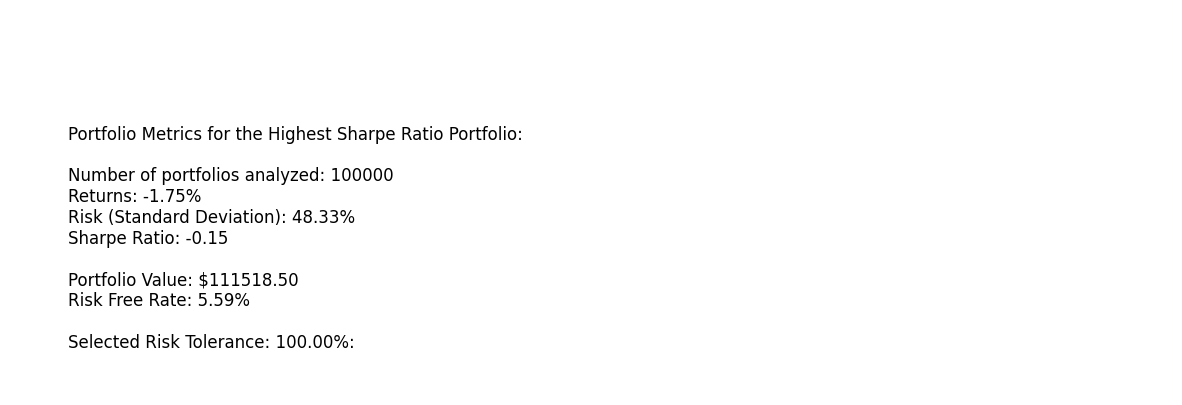

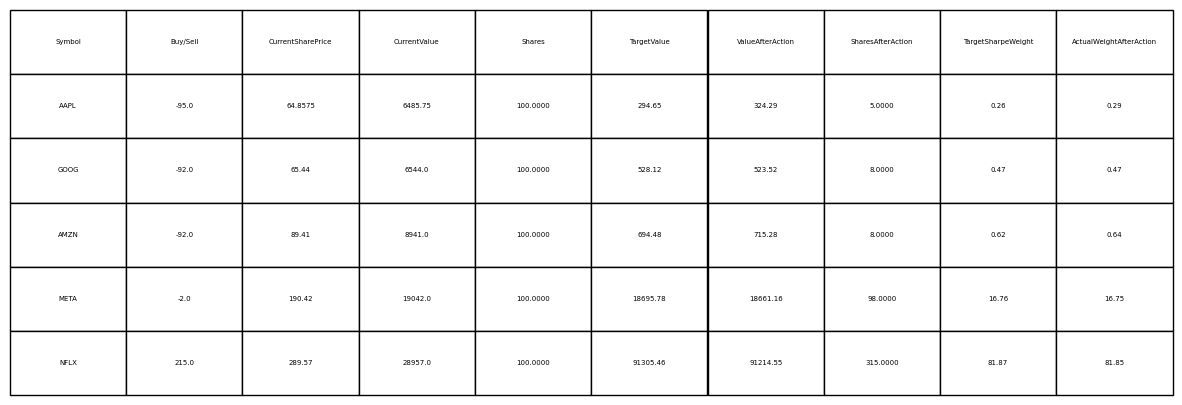

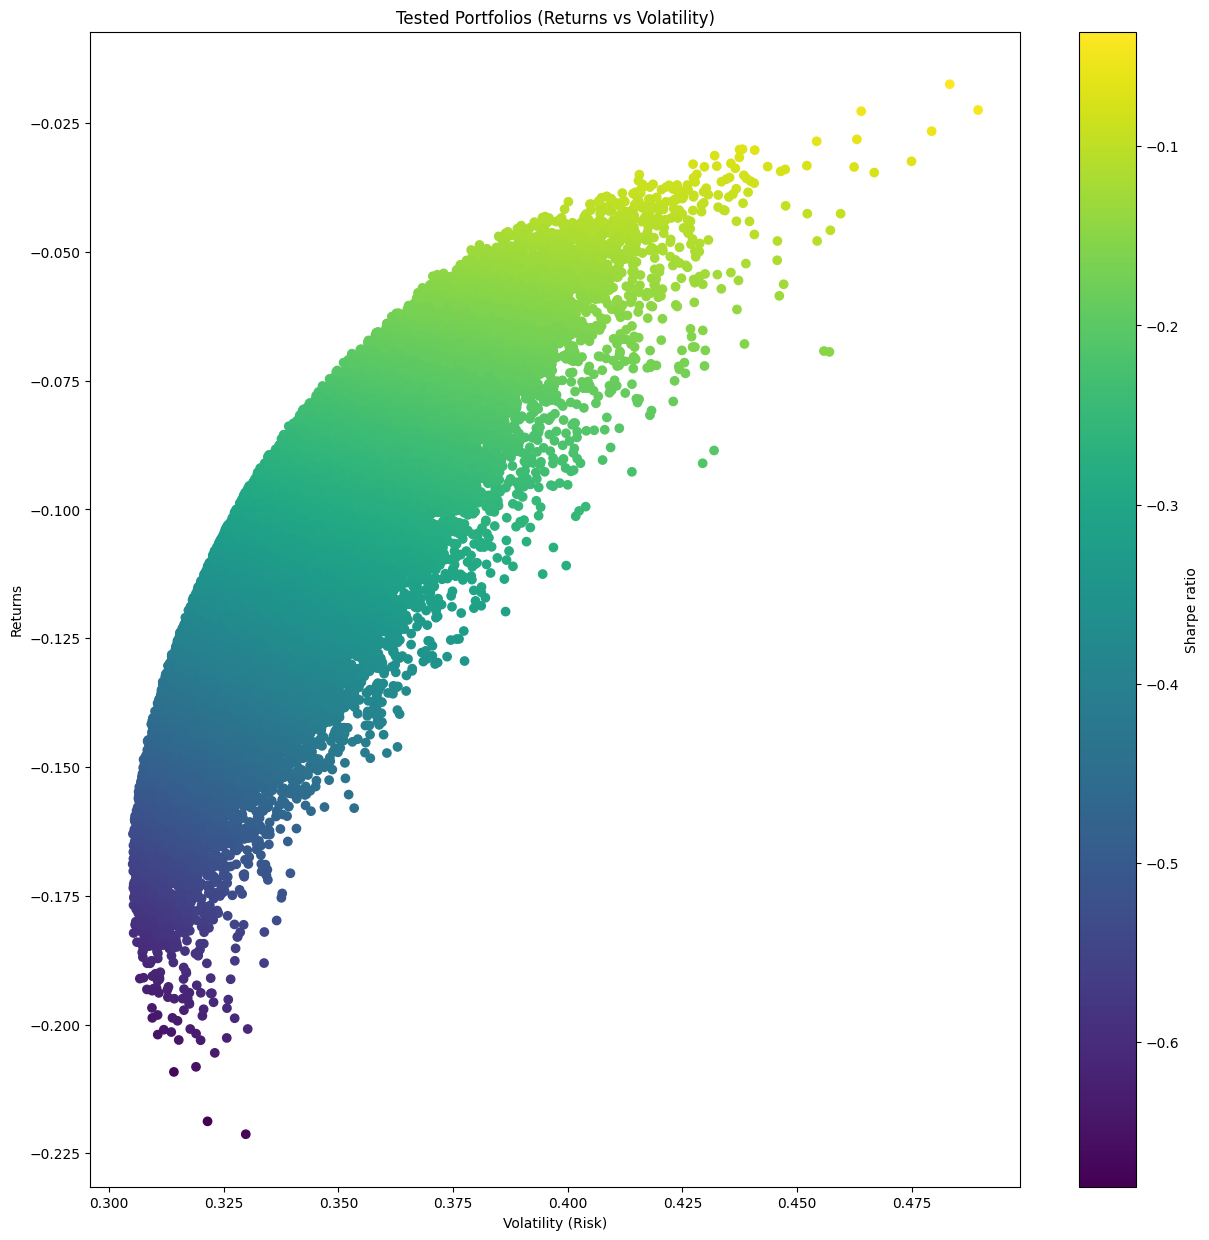

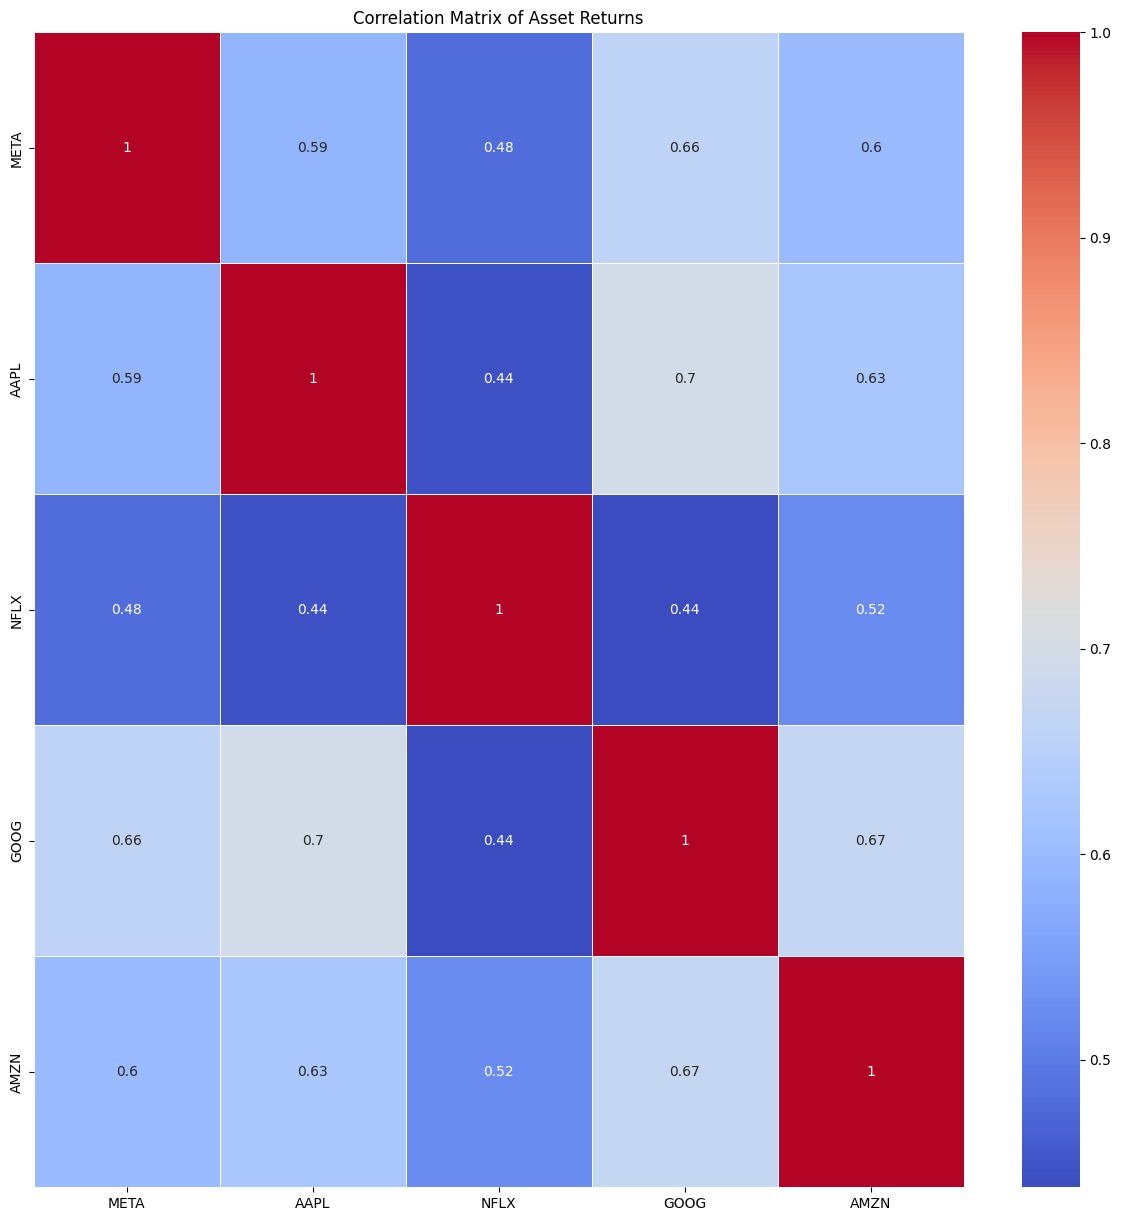

In [9]:
# Get the price history for all stocks and ETFs
stock_history = f.get_stock_history(STOCKS, NUMBER_OF_DAYS, API_KEY)
# Get the daily return (price difference) for all stocks and ETFs
return_stocks = f.get_return_stocks(stock_history)
portfolio_dfs = f.get_montecarlo_simulation(NUMBER_OF_PORTFOLIOS, STOCKS, return_stocks, TRADING_DAYS, RF, RISK)
# Get the recommended weights for each stock and ETF
recommendations = f.get_recommendations(portfolio_dfs, current_portfolio, ACCT, STOCKS, stock_history)
# Display results
f.plot_portfolio_metrics(portfolio_dfs, NUMBER_OF_PORTFOLIOS, ACCT, RF, RISK)
f.plot_portfolio_changes(recommendations)
f.plot_risk_scatterplot(portfolio_dfs)
f.plot_correlation_matrix(return_stocks)